In [40]:
import sys
import os
sys.path.append(os.path.abspath("DatasetGeneration/DataGenerator"))

from DatasetGeneration.DataGenerator.utils2 import save_kde, load_kde, TruncatedKDE
from DatasetGeneration.DataGenerator.utils import read_dataset
from DatasetGeneration.DataGenerator.scgen import SCGen
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
import shutil
import random


def event_image(array_from_h5, img_size: tuple[int, int], normalize: bool = False) -> np.ndarray:
        """
        Rasterise the selected event to a 2-D hit-count map.

        Parameters
        img_size   : (H, W) in pixels
        normalize  : if True, scale to [0,1]

        Returns
        np.ndarray[H,W]   float32 image
        """

        h, w = img_size
        (x_min, x_max), (y_min, y_max) = (-600, 600), (-600, 600)
        sx = (w - 1) / (x_max - x_min)
        sy = (h - 1) / (y_max - y_min)

        img = np.zeros((h, w), dtype=np.float32)
        for ring in array_from_h5['rings']:
            if not len(ring):
                continue
            x_pix = np.rint((ring[:, 0] - x_min) * sx).astype(int)
            y_pix = np.rint((y_max - ring[:, 1]) * sy).astype(int)         # y origin at top
            m = (x_pix >= 0) & (x_pix < w) & (y_pix >= 0) & (y_pix < h)
            img[y_pix[m], x_pix[m]] += 1

        if normalize and img.max() > 0:
            img /= img.max()

        return img

def fromSCgen_to_YOLOformat(scgen, output_dir: str, image_size=(256, 256), visibility=2, square_box=False, h5_file=False):
    
    """
    Organizza i dati generati secondo la gerarchia voluta da YOLO, con file txt riportanti bounding box e keypoint centrato.

    Parameters
    ----------
    scgen : SCGen
        Oggetto con dataset già generato.
    output_dir : str
        Cartella di output.
    image_size : tuple[int, int]
        Risoluzione immagini finali (H, W).
    visibility : int
        Visibilità keypoint (2 = visibile).
    """
    
    img_h, img_w = image_size
    images_dir = os.path.join(output_dir, "images", "train")
    labels_dir = os.path.join(output_dir, "labels", "train")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    if h5_file is False:
        x_min, x_max = scgen.detector_size[0]
        y_min, y_max = scgen.detector_size[1]
    else:
        x_min, x_max = (-600, 600)
        y_min, y_max = (-600, 600)
    
    for idx in range(len(scgen)):
        # 1. Salva immagine con risoluzione immagine impostata
        if h5_file is False: img = scgen.event_image(idx, (img_h, img_w), normalize=False)
        else: img = event_image(scgen[idx], (img_h, img_w), normalize=False)
        img_uint8 = (255 * img / img.max()).astype(np.uint8) if img.max() > 0 else img.astype(np.uint8)
        img_name = f"event_{idx}.jpg"
        cv2.imwrite(os.path.join(images_dir, img_name), img_uint8)

        # 2. Estrai dati MA sono tutti normalizzati (usando le coordinate del rivelatore)
        event = scgen[idx]
        centers = event['centers']
        rings = event['rings']
        radii = event['radii']

        with open(os.path.join(labels_dir, f"event_{idx}.txt"), "w") as f:
            for i, (cx, cy) in enumerate(centers):
                ring = rings[i]
                if len(ring) == 0:
                    continue

                # Bounding box
                x_min_ring, y_min_ring = ring.min(axis=0)
                x_max_ring, y_max_ring = ring.max(axis=0)
                x_c = (x_min_ring + x_max_ring) / 2
                y_c = (y_min_ring + y_max_ring) / 2
                
                # Trasformazione coordinate nel sistema immagine
                # x va da x_min a x_max → mappato a [0, img_w]
                # y va da y_max a y_min (flip) → mappato a [0, img_h]
                def to_img_coords(x, y):
                    x_img = (x - x_min) / (x_max - x_min)
                    y_img = (y_max - y) / (y_max - y_min)  # Flip y
                    return x_img, y_img
                
                if square_box == False:    
                    w = x_max_ring - x_min_ring
                    h = y_max_ring - y_min_ring
                    x_center, y_center = to_img_coords(x_c, y_c)
                else:
                    w = radii[i] * 2
                    h = radii[i] * 2
                    x_center, y_center = to_img_coords(cx, cy)
                    
                if x_center < 0 or x_center > 1 or y_center < 0 or y_center > 1:
                    continue  # Skip bounding boxes outside image bounds
                
                width = w / (x_max - x_min)
                height = h / (y_max - y_min)

                kpt_x, kpt_y = to_img_coords(cx, cy)
                if kpt_x < 0 or kpt_x > 1 or kpt_y < 0 or kpt_y > 1:
                    continue  # Skip keypoints outside image bounds

                # YOLO-Pose format
                line = f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f} {kpt_x:.6f} {kpt_y:.6f} {visibility}\n"
                f.write(line)
    
    
    

def visualize_yolo_pose_labels(image_path: str, label_path: str, box_color=(0, 255, 0), kp_color=(255, 0, 0), kp_radius=1):
        """
        Visualizza un'immagine con bounding box e keypoints YOLO-Pose disegnati sopra.

        Parameters
        ----------
        image_path : str
            Percorso dell'immagine (JPG).
        label_path : str
            Percorso del file .txt corrispondente.
        box_color : tuple[int, int, int]
            Colore della bounding box in BGR.
        kp_color : tuple[int, int, int]
            Colore del keypoint (centro).
        kp_radius : int
            Raggio del cerchio del keypoint.
        """
        # 1. Carica immagine
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Immagine non trovata: {image_path}")
        h, w = image.shape[:2]

        # 2. Carica etichette
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 8:
                continue  # skip incomplete rows
            class_id = int(parts[0])
            x_c, y_c, box_w, box_h = map(float, parts[1:5])
            kx, ky, v = map(float, parts[5:8])

            # Denormalizza bounding box
            x_center = int(x_c * w)
            y_center = int(y_c * h)
            width = int(box_w * w)
            height = int(box_h * h)
            x1 = x_center - width // 2
            y1 = y_center - height // 2
            x2 = x_center + width // 2
            y2 = y_center + height // 2

            # Disegna bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), box_color, 1)

            # Disegna keypoint se visibile
            if int(v) > 0:
                kp_x = int(kx * w)
                kp_y = int(ky * h)
                cv2.circle(image, (kp_x, kp_y), kp_radius, kp_color, -1)

        # 3. Visualizza
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 8))
        plt.imshow(image_rgb)
        plt.title(f"Image: {image_path}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()




def split_train_val(dataset_dir, split_ratio=0.8, seed=42):
    """
    Divide immagini e label in train e val in base a split_ratio.

    Parameters
    ----------
    dataset_dir : str
        Cartella base del dataset (che contiene 'images/train' e 'labels/train').
    split_ratio : float
        Percentuale di dati da tenere per il train (default 0.8).
    seed : int
        Seed per random shuffle (default 42).
    """

    random.seed(seed)

    # Percorsi originali (assumo immagini e label sotto train/)
    images_train_dir = os.path.join(dataset_dir, "images", "train")
    labels_train_dir = os.path.join(dataset_dir, "labels", "train")

    # Nuovi percorsi per val
    images_val_dir = os.path.join(dataset_dir, "images", "val")
    labels_val_dir = os.path.join(dataset_dir, "labels", "val")

    os.makedirs(images_val_dir, exist_ok=True)
    os.makedirs(labels_val_dir, exist_ok=True)

    # Lista di tutti i file immagine nella cartella train
    all_images = [f for f in os.listdir(images_train_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    all_images.sort()  # opzionale: per coerenza

    # Shuffle e split
    random.shuffle(all_images)
    split_index = int(len(all_images) * split_ratio)

    train_images = all_images[:split_index]
    val_images = all_images[split_index:]

    # Sposta immagini e label corrispondenti nella cartella val
    for img_name in val_images:
        # Sposta immagine
        src_img_path = os.path.join(images_train_dir, img_name)
        dst_img_path = os.path.join(images_val_dir, img_name)
        shutil.move(src_img_path, dst_img_path)

        # Sposta label corrispondente .txt
        label_name = os.path.splitext(img_name)[0] + ".txt"
        src_label_path = os.path.join(labels_train_dir, label_name)
        dst_label_path = os.path.join(labels_val_dir, label_name)

        if os.path.exists(src_label_path):
            shutil.move(src_label_path, dst_label_path)
        else:
            print(f"Attenzione: manca il file label {label_name}")

    print(f"Dataset diviso in {len(train_images)} immagini per train e {len(val_images)} immagini per val.")



def create_yaml_file(dataset_root, name_yaml):
    """
    Genera un file YAML per YOLOv11 keypoint detection.

    Parameters:
    - dataset_root: path assoluto della cartella contenente immagini e label
    - name_yaml: solo il nome del file YAML da creare (es. '100.yaml')
    """

    lines = []
    lines.append(f"path: {dataset_root}")
    lines.append("train: images/train")
    lines.append("val: images/val\n")
    lines.append("nc: 1")
    lines.append("names: ['circle']")
    lines.append("kpt_shape: [1, 3]")

    content = "\n".join(lines)

    # Path completo al file da salvare nella stessa cartella
    yaml_path = os.path.join(dataset_root, name_yaml)

    with open(yaml_path, "w") as f:
        f.write(content)

    print(f"YAML creato in: {yaml_path}")


# ---------------------------------------------------------------------------------------------------------------------- #


        
# Import of momentum and centers distributions
ptypes = [211, 321, 2212, 11, 13]
log_momenta_dist = {}
for ptype in ptypes:
    log_momenta_dist[ptype] = load_kde(f'DatasetGeneration/distributions/log_momenta_kdes/{ptype}-kde.npz')
centers_dist = load_kde('DatasetGeneration/distributions/centers_R1-kde.npz')
radial_noise = (0, 1.5)  # Mean and standard deviation for radial noise

In [35]:
# Create the SCGen instance
scgen = SCGen(
    particle_types=ptypes,
    refractive_index=1.0014,
    detector_size=((-600, 600), (-600, 600)),
    momenta_log_distributions=log_momenta_dist,
    centers_distribution=centers_dist,
    radial_noise=radial_noise,
    N_init=20,
    max_radius=100.0
)


# Generate the data
N = 50000
N_rings = (160, 180)
dataset = scgen.generate_dataset(
    num_events=N, # Giovanni ha messo 200 eventi
    num_particles_per_event=N_rings, # Giovanni ha messo (160,180) tuple 
    parallel=True, # NOTA: lasciare TRUE per generare gli eventi in parallelo, altrimenti NON FUNZIONA!
    batch_size=128,
    progress_bar=True
)

print(f"Generated {len(dataset)} events with {sum(len(event['rings']) for event in dataset)} total rings.")


directory = r'/user/gr1/delphi/dghezzi/KeyPoint Detection/YOLO_dataset/45000_5000_160_180_800'

if os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)
    
scgen.save_dataset(f'{directory}.h5')

100%|██████████| 50000/50000 [1:27:37<00:00,  9.51it/s]


Generated 50000 events with 8500938 total rings.


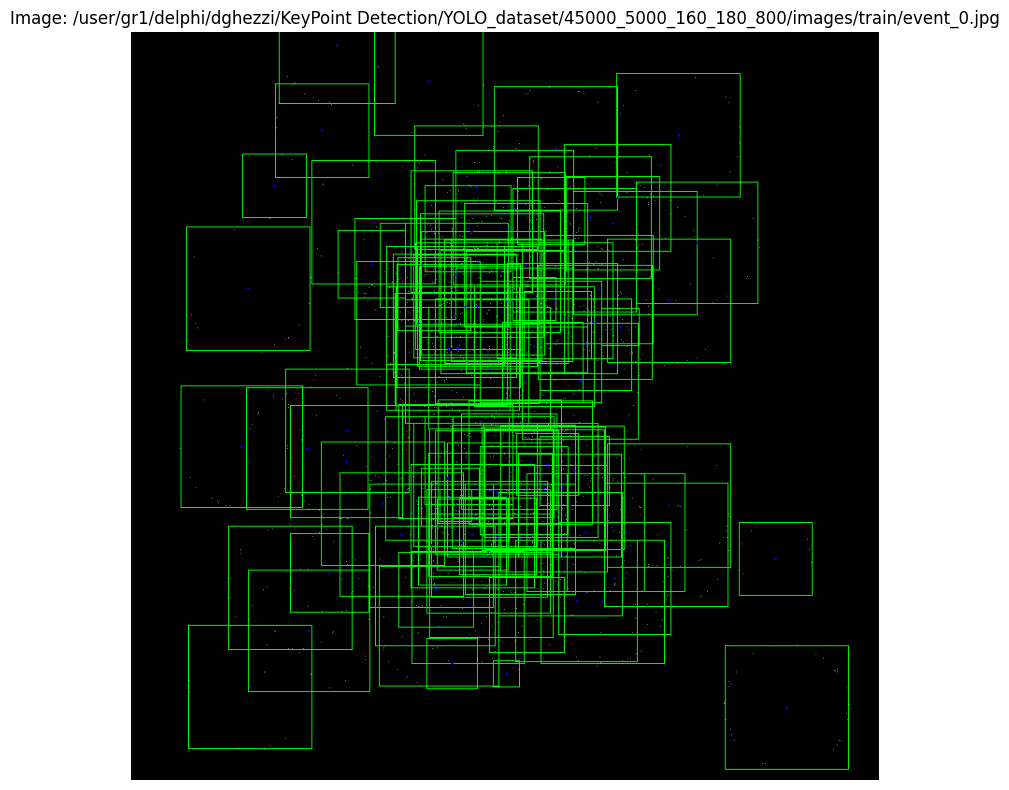

Dataset diviso in 45000 immagini per train e 5000 immagini per val.
YAML creato in: /user/gr1/delphi/dghezzi/KeyPoint Detection/YOLO_dataset/45000_5000_160_180_800/45000_5000_160_180_800.yaml


In [43]:
#dataset = read_dataset(f'{directory}.h5') # ricordare di mettere h5_file=True
fromSCgen_to_YOLOformat(scgen, directory, image_size=(800, 800), square_box=True, h5_file=False)

visualize_yolo_pose_labels(
    image_path= directory + r"/images/train/event_0.jpg", 
    label_path= directory + r"/labels/train/event_0.txt",
)

split_train_val(directory, split_ratio=0.9)
create_yaml_file(dataset_root=directory, name_yaml='45000_5000_160_180_800.yaml')